# CSV -> NPZ (PID)

## 실험 1
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도 - 측정온도

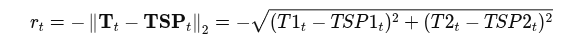

In [11]:
import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline1_T-Tsp_bbb.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[:-1] - df[['TSP1','TSP2']].values[:-1],
        axis=1,
        keepdims=True
    )
    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")

50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

## 실험 2
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도(t+1) - 측정온도(t+1)

t시점의 Q를 제어할 경우 t시점의 T1,T2에 영향을 끼치는 것이 아닌 t+1시점의 T1,T2가 영향을 끼치게 됨.
그렇기에 다음 시점의 목표온도와 측정온도의 차이를 보상함수로 지정함.

In [17]:

import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline2_T-Tsp_next.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2
i=0
for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        i+=1
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[1:] - df[['TSP1','TSP2']].values[1:],
        axis=1,
        keepdims=True
    )
    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")
print(i)


50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

## 실험 3

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2


앞선 방식들은 올바른 액션을 취해도 현재 상태가 좋지 않으면 보상 또한 좋지 않았다.

즉, 보상이 액션이 아닌 상태에 의존적이었다.

ex) 

Tsp가 60일때

    T가 20일 때 Q를 100으로 하여도 -40의 보상

    T가 50일 때 Q를 100으로 하면 -10의 보상

즉, 둘 다 올바른 행동이었지만 상태에 따라 보상이 달라진다.

- 보상:  PBRS(Potential-Based Reward Shaping) 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> rt=0 //개선정도만이 보상의 척도가 됨.

-> reward_t = rt + γ * Φ(t+1) - Φ(t) 




현재의 행동으로 인해 다음 상태의 개선정도가 보상으로서 작용된다.

| 상황             | PBRS 보상     | 유도되는 행동  |
|------------------|---------------|----------------|
| 목표에 가까워짐  | 양의 보상 ↑   | 접근           |
| 그대로 유지      | 거의 0        | 정지 유지       |
| 목표에서 멀어짐  | 음의 보상 ↓   | 복귀 시도       |


In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline3_PBRS.npz"


all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    print(file_path)

    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions = df[['Q1','Q2']].values[:-1]
    
    # PBRS 보상
    gamma = 0.99
    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=True)
    rewards = gamma * phi[1:] - phi[:-1]

    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    print(rewards)
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
[[0.59556863]
 [0.06463704]
 [0.20414279]
 ...
 [0.10038056]
 [0.15550695]
 [0.01416886]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
[[ 0.76922018]
 [ 0.11779328]
 [-0.4410208 ]
 ...
 [ 0.06400526]
 [ 0.01689866]
 [ 0.08236437]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
[[ 0.24505257]
 [-0.04454454]
 [ 0.03984181]
 ...
 [ 0.14653594]
 [ 0.05805235]
 [ 0.08750143]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
[[0.89652303]
 [0.39404965]
 [0.48258058]
 ...
 [0.06147461]
 [0.09004068]
 [0.03092074]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
[[0.58786234]
 [0.30728233]
 [0.10023702]
 ...
 [0.32768054]
 [0.2596934 ]
 [0.14127559]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
[[0.79267365]
 [0.31840967]
 [0.23548622]
 ...
 [0.18168177]
 [0.02151217]
 [0.05523584]

## 실험 4

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상:  PBRS + 기존보상함수 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> rt = 목표온도(t+1) - 측정온도(t+1) //개선정도와 더불어 측정온도와 목표온도 사이의 차이를 보상으로 함.

-> reward_t = rt + γ * Φ(t+1) - Φ(t) 

개선정도와 기존 보상의 정규화를 위해 min, max 정규화를 시도함.


In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 경로 설정
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline4_PBRS_reward_norm.npz"


all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]

    # PBRS 보상
    gamma = 0.99
    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=True)
    pbrs_term = gamma * phi[1:] - phi[:-1]

    # ② 오차 기반 보상: 다음 시점에서의 목표 온도와의 거리
    error_term = -np.linalg.norm(
        df[['T1','T2']].values[1:] - df[['TSP1','TSP2']].values[1:],
        axis=1,
        keepdims=True
    )
    # Min-Max 정규화
    pbrs_norm = (pbrs_term - pbrs_term.min()) / (pbrs_term.max() - pbrs_term.min() + 1e-8)
    error_norm = (error_term - error_term.min()) / (error_term.max() - error_term.min() + 1e-8)

    # 결합 보상
    rewards = pbrs_norm + error_norm

    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    print(rewards)
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")

50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
[[1.21789302]
 [1.18078647]
 [1.19020243]
 ...
 [1.61412127]
 [1.62064841]
 [1.60909109]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
[[1.58994399]
 [1.56160619]
 [1.51105082]
 ...
 [1.8408298 ]
 [1.83825418]
 [1.84393246]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
[[1.82062633]
 [1.80656472]
 [1.80972139]
 ...
 [1.63249831]
 [1.62806168]
 [1.62916329]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
[[0.99496414]
 [0.91815076]
 [0.93492237]
 ...
 [1.72023755]
 [1.72545276]
 [1.71551155]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
[[1.35819323]
 [1.35032659]
 [1.33853544]
 ...
 [1.39736558]
 [1.39707839]
 [1.39077624]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
[[0.99700588]
 [0.96625759]
 [0.95743158]
 ...
 [1.89761724]
 [1.88772398]
 [1.89072296]]
/home/minc

## 실험5

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 온도변화량(T(t-1) - T(t))를 추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t),  T1(t-1) - T1(t), T2(t-1) - T2(t) 
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [18]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 데이터 경로
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline5_extra_state_deltaT.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values
    
    dT1 = T1[:-1] - T1[1:]
    dT2 = T2[:-1] - T2[1:]
    
    
    
    obs = np.stack([T1[1:-1], T2[1:-1], TSP1[1:-1], TSP2[1:-1], dT1[:-1], dT2[:-1]], axis=1)
    
    next_obs = np.stack([T1[2:], T2[2:], TSP1[2:], TSP2[2:], dT1[1:], dT2[1:]], axis=1)
    
    actions = np.stack([Q1[1:-1], Q2[1:-1]], axis=1)

    
    rewards = -np.linalg.norm(
        np.stack([T1[2:] - TSP1[2:], T2[2:] - TSP2[2:]], axis=1),
        axis=1,
        keepdims=True
    )
    
    terminals = np.zeros((len(obs), 1), dtype=np.float32)
    terminals[-1] = 1.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)
    
dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions, {dataset['observations'].shape[1]} ")
print(f"→ {npz_output_path}")



50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

## 실험6

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 직전(t-1) Q를추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t), Q1(t-1), Q2(t-1)
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [14]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 데이터 경로
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline6_extra_state_prevQ.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values
    
    dT1 = T1[:-1] - T1[1:]
    dT2 = T2[:-1] - T2[1:]
    
    
    
    obs = np.stack([T1[1:-1], T2[1:-1], TSP1[1:-1], TSP2[1:-1], Q1[:-2], Q2[:-2]], axis=1)
    
    next_obs = np.stack([T1[2:], T2[2:], TSP1[2:], TSP2[2:], Q1[1:-1], Q2[1:-1]], axis=1)
    
    actions = np.stack([Q1[1:-1], Q2[1:-1]], axis=1)

    
    rewards = -np.linalg.norm(
        np.stack([T1[2:] - TSP1[2:], T2[2:] - TSP2[2:]], axis=1),
        axis=1,
        keepdims=True
    )
    
    terminals = np.zeros((len(obs), 1), dtype=np.float32)
    terminals[-1] = 1.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)
    
dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")



50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

## 실험7

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 직전(t-1) Q와 온도변화량(T(t-1) - T(t))를 추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t), Q1(t-1), Q2(t-1), T1(t-1) - T1(t), T2(t-1) - T2(t) 
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [13]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 데이터 경로
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline7_extra_state.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values
    
    dT1 = T1[:-1] - T1[1:]
    dT2 = T2[:-1] - T2[1:]
    
    
    
    obs = np.stack([T1[1:-1], T2[1:-1], TSP1[1:-1], TSP2[1:-1], Q1[:-2], Q2[:-2], dT1[:-1], dT2[:-1]], axis=1)
    
    next_obs = np.stack([T1[2:], T2[2:], TSP1[2:], TSP2[2:], Q1[1:-1], Q2[1:-1], dT1[1:], dT2[1:]], axis=1)
    
    actions = np.stack([Q1[1:-1], Q2[1:-1]], axis=1)

    
    rewards = -np.linalg.norm(
        np.stack([T1[2:] - TSP1[2:], T2[2:] - TSP2[2:]], axis=1),
        axis=1,
        keepdims=True
    )
    
    terminals = np.zeros((len(obs), 1), dtype=np.float32)
    terminals[-1] = 1.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)
    
dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")



50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/